In [1]:
import os
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
from dpipe.io import load, choose_existing
from dpipe.torch import load_model_state

from ttt_lib.q_learning import PolicyNetworkQ, PolicyPlayer, play_game, train_q_learning, PolicyNetworkRandom,\
    play_duel
from ttt_lib.field import Field

In [2]:
Q_EXP_PATH = choose_existing(
    Path('/nmnt/x2-hdd/experiments/rl/q_3x3'),
)

os.listdir(Q_EXP_PATH)

['q2_final',
 'q2_augm_long',
 'q2_augm_long_val',
 'q2_final_fix',
 'q1_final',
 'q1_final_fix']

# Visualization

In [3]:
exp_path = Q_EXP_PATH / 'q2_final'

In [4]:
def choose_model(path):
    models = [m for m in os.listdir(path) if 'model' in m]
    if 'model.pth' in models:
        return 'model.pth'
    else:
        n = np.max([int(m.strip('.pth').split('_')[-1]) for m in models])
        return f'model_{n}.pth'

In [5]:
device = 'cpu'
n = 3
kernel_len = 3
cnn_features = (128, 64)

field = Field(n=n, kernel_len=kernel_len, device=device, check_device=device)
model = PolicyNetworkQ(n=n, structure=cnn_features)
load_model_state(model, exp_path / choose_model(exp_path))

eps = 0
player = PolicyPlayer(model=model, field=field, eps=eps, device=device)
player.eval()

In [6]:
s_history, f_history, a_history, q_history, q_max_history, p_history, value\
    = play_game(player=player, train=False, augm=False)

/nmnt/media/home/boris/workspace/RL2021_Final_Project/ttt_lib/q_learning.py:200: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  argmax_avail_action_idx = random.choice(torch.where(avail_p == avail_p.max(), 1., 0.).nonzero()).item()


In [7]:
# code to visualise (s, a) sequence

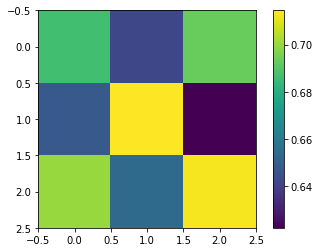

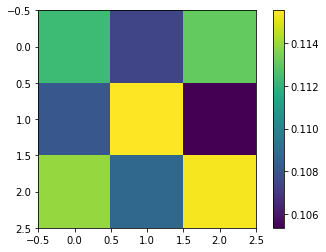

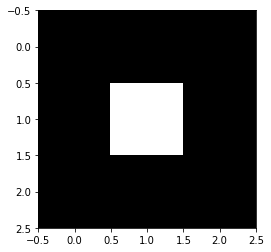

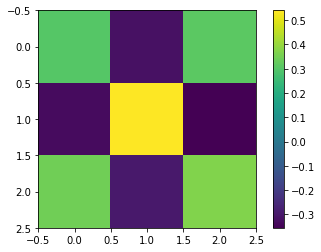

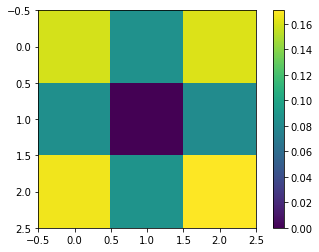

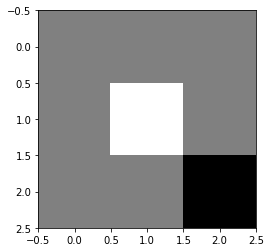

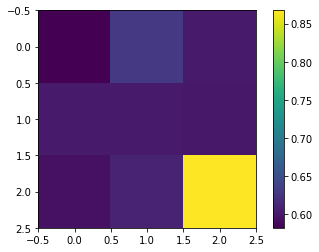

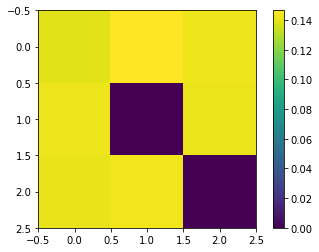

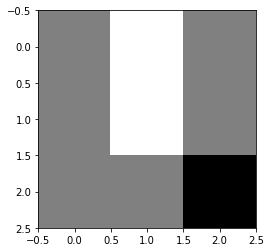

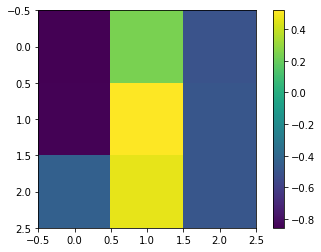

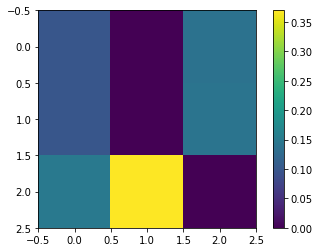

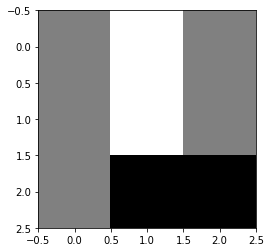

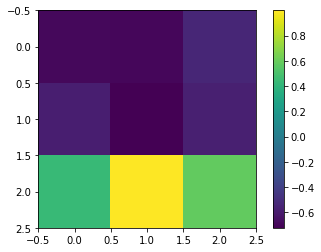

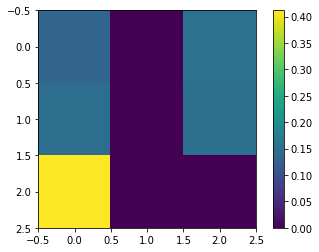

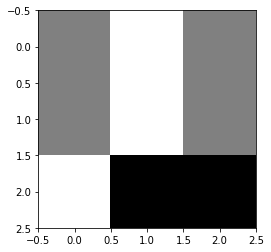

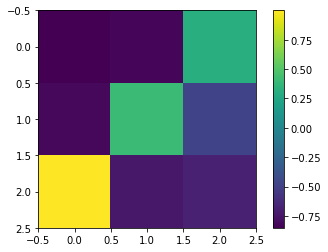

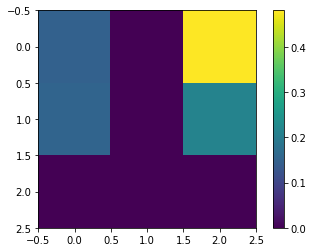

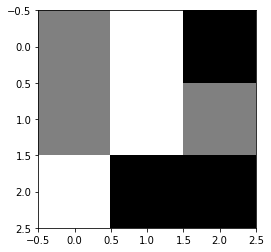

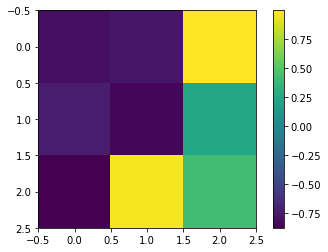

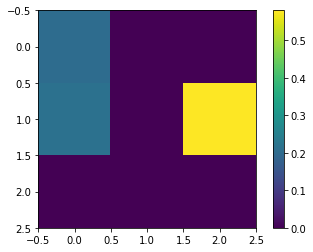

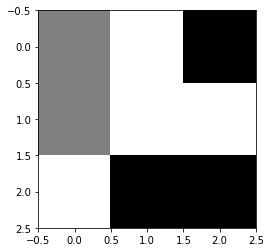

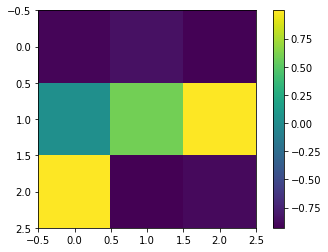

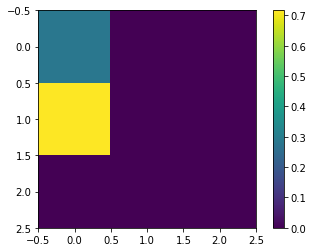

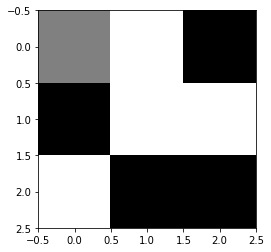

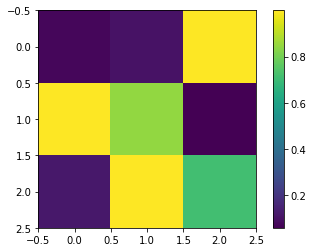

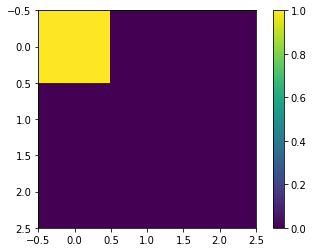

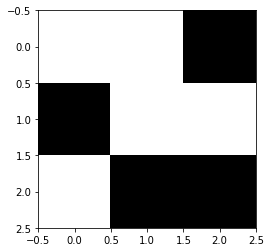

In [7]:
field_v = Field(n, kernel_len)
for s, a, q, p in zip(s_history, a_history, q_history, p_history):
    plt.imshow(q.detach().numpy())
    plt.colorbar()
    plt.show()
    
    plt.imshow(p.detach().numpy())
    plt.colorbar()
    plt.show()

    i, j = a // n, a % n
    field_v.set_state(s)
    field_v.make_move(i, j)
    field_v.show_field()

## Check some manual games

In [8]:
player.update_field(np.zeros((n, n), dtype='float32'))

### Algorithm's policy w/o move

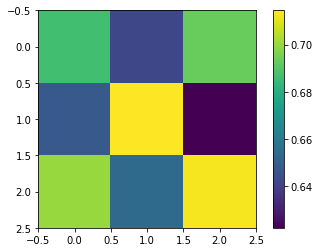

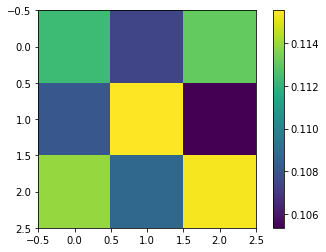

tensor(4)


In [9]:
q, p = player.forward_state()

plt.imshow(q.detach().cpu().numpy())
plt.colorbar()
plt.show()

plt.imshow(p.detach().cpu().numpy())
plt.colorbar()
plt.show()

print(p.argmax())

### Algorithm's move

None


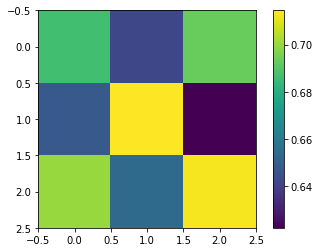

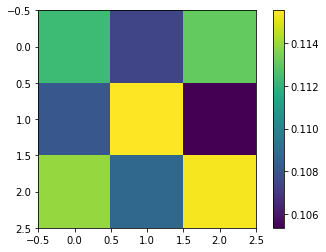

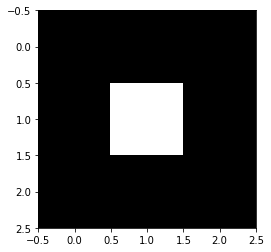

In [10]:
q, p, a, v = player.action(train=False)

print(v)

plt.imshow(q.detach().cpu().numpy())
plt.colorbar()
plt.show()

plt.imshow(p.detach().cpu().numpy())
plt.colorbar()
plt.show()

player.field.show_field()

### Manual move

None


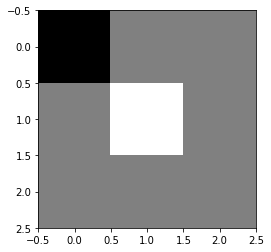

In [11]:
_, _, _, v = player.manual_action(0, 0)

print(v)

player.field.show_field()

## Duel vs random

In [12]:
field_duel = Field(n=n, kernel_len=kernel_len, device=device, check_device=device)

eps = 0
player_model = PolicyPlayer(model=model, field=field_duel, eps=0, device=device)
player_model_1 = PolicyPlayer(model=model, field=field_duel, eps=0, device=device)

model_random = PolicyNetworkRandom(n=n)
player_random = PolicyPlayer(model=model_random, field=field_duel, eps=1, device=device)

In [13]:
ahs, ws = [], []
for _ in range(1000):
    sh, fh, ah, qh, ph, w = play_duel(player_model, player_random, return_result_only=False)
    ahs.append(ah)
    ws.append(w)

In [14]:
np.mean(np.array(ws) == 1)

0.991